In [ ]:
# Bibliotecas  auxiliares
import pandas as pd
import numpy as np

# Ler e visualizar as imagens
import matplotlib.pyplot as plt
%matplotlib inline

# Criar um teste de validação
from sklearn.model_selection import train_test_split

# Testar a acurácia do modelo
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch bibliotecas e módulos
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

## **Carregar os dados CIFAR-10, fazer o pré processamento e visualização dos dados**

In [ ]:
#Provavelmente colocar em cada época:
#torch.cuda.empty_cache

def unpickle(file_path):
  import pickle 
  
  with open(file_path, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

In [ ]:
file_path = '/content/drive/MyDrive/PytorchCNN/cifar-10-batches-py/data_batch_'
file_batchs = ['1','2','3','4','5']

In [ ]:
current_file_path = file_path + '1'
current_data_batch = unpickle(current_file_path)
data = np.array(current_data_batch[b'data'])
labels = np.array(current_data_batch[b'labels'])

for i in range(1, len(file_batchs)):
  current_file_path = file_path + file_batchs[i]
  current_data_batch = unpickle(current_file_path)
  
  current_array = np.array(current_data_batch[b'data'])
  current_label = np.array(current_data_batch[b'labels'])

  data = np.concatenate((data, current_array),axis=0)
  labels = np.concatenate((labels, current_label),axis=0)

data = data/255
print(data.shape)
print(labels)

(50000, 3072)
[6 9 9 ... 9 1 1]


In [ ]:
data = data.reshape(len(data),3,32,32).transpose(0,2,3,1)
print(data.shape)

(50000, 32, 32, 3)


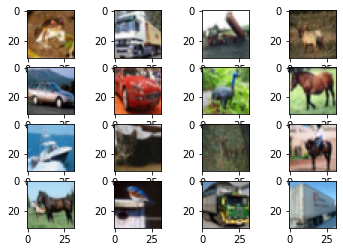

In [ ]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(data[i])

plt.show()

# **Divisão do teste e validação para as imagens**




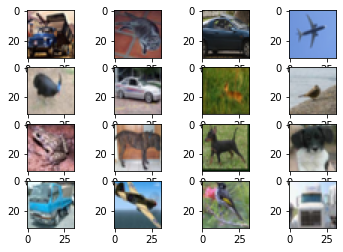

[9 3 1 0 2 1 4 2 6 5 5 5 9 0 2 9]


In [ ]:
# Dividir as 50 mil imagens em 45 mil para treino e 5 mil para teste
train_x, val_x, train_y, val_y = train_test_split(data, labels, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

# Aplicando o reshape e transpose para visualização 

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_x[i])

plt.show()

print(train_y[:16])

In [ ]:
#.transpose(0,2,3,1)
# Convertendo os numpy array para formato torch
train_x = train_x.transpose(0, 3, 1, 2)
val_x = val_x.transpose(0, 3, 1, 2)


# Imagens que serão entradas para o Treino
train_x  = torch.from_numpy(train_x)

# ID's que serão saídas para o Treino
train_y = torch.from_numpy(train_y)

# Imagens que serão entradas para o Teste
val_x  = torch.from_numpy(val_x)

# ID's que serão saídas para o Teste
val_y = torch.from_numpy(val_y)



train_x = torch.as_tensor(train_x, dtype=torch.float32)
val_x = torch.as_tensor(val_x, dtype=torch.float32)


# torch([45000, 32, 32, 3])
train_x.shape, train_y.shape

(torch.Size([45000, 3, 32, 32]), torch.Size([45000]))

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(256, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
def train(epoch):
    torch.cuda.empty_cache
    tr_loss = 0
    # Set de treino
    x_train, y_train = Variable(train_x), Variable(train_y)
    # Set de validação
    x_val, y_val = Variable(val_x), Variable(val_y)
    # Convertendo para Cuda
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # Limpando os gradientes
    optimizer.zero_grad()
    
    # Prediction do Treino e Validação
    output_train = model(x_train)
    output_val = model(x_val)

    # Salvando loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # Salvar os pesos
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    # Mostrar a validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [ ]:
# Número de épocas
EPOCHS = 15
model.train()

# Listas para pós visualização
train_losses = []
val_losses = []

# Treinar o modelo
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch :  1 	 loss : tensor(2.4761, grad_fn=<NllLossBackward>)
Epoch :  2 	 loss : tensor(8.2948, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(8.5471, grad_fn=<NllLossBackward>)
Epoch :  4 	 loss : tensor(4.8201, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(3.9602, grad_fn=<NllLossBackward>)
Epoch :  6 	 loss : tensor(2.8719, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(2.5777, grad_fn=<NllLossBackward>)
Epoch :  8 	 loss : tensor(2.3745, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(2.3053, grad_fn=<NllLossBackward>)
Epoch :  10 	 loss : tensor(2.3094, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(2.3107, grad_fn=<NllLossBackward>)
Epoch :  12 	 loss : tensor(2.3118, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(2.3126, grad_fn=<NllLossBackward>)
Epoch :  14 	 loss : tensor(2.3131, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(2.3132, grad_fn=<NllLossBackward>)


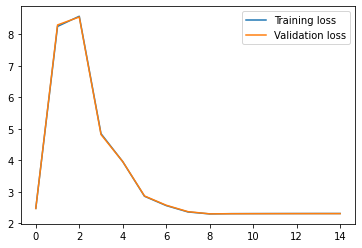

In [ ]:
# Plotar o loss do treino e validação 
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()